In [1]:
import torch
import torch.nn as nn
import numpy as np
from collections import deque
from sklearn.preprocessing import StandardScaler
from mtad_gat import MTAD_GAT 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from scipy.io import loadmat
from utils import SlidingWindowDataset, get_target_dims

In [2]:
pwd

'/projects/prestosolution/MTAD-GAT'

In [3]:
def load_model(model_path, model_params, device='cpu'):
    model = MTAD_GAT(**model_params)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [4]:
def prepare_data(mat_data_path, window_size, target_dims, normalize=True):
    # Load data from .mat files
    data_dict = loadmat(mat_data_path)
    
    # Extract features
    features = [data_dict[f'feature{i+1}'].flatten() for i in range(len(data_dict) - 3)]
    data = np.column_stack(features)

    if normalize:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    
    data_tensor = torch.from_numpy(data).float()
    dataset = SlidingWindowDataset(data_tensor, window_size, target_dims)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    
    return data_loader, data_tensor

In [5]:
def predict_anomalies(model, data_loader, target_dims=None, device='cpu'):
    model.eval()
    anomaly_scores = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            
            preds, recons = model(x)
            
            if target_dims is not None:
                x = x[:, :, target_dims]
                y = y[:, :, target_dims].squeeze(-1)
            
            if preds.ndim == 3:
                preds = preds.squeeze(1)
            if y.ndim == 3:
                y = y.squeeze(1)
            
            forecast_loss = torch.sqrt(nn.MSELoss()(y, preds)).item()
            recon_loss = torch.sqrt(nn.MSELoss()(x, recons)).item()
            total_loss = forecast_loss + recon_loss

            anomaly_scores.append(total_loss)
    
    return np.array(anomaly_scores)

In [6]:
def load_anomaly_info(label_path):
    anomaly_info = loadmat(label_path)
    point_anomalies = anomaly_info['point']
    contextual_anomalies = anomaly_info['contextual']
    return point_anomalies, contextual_anomalies

In [17]:
def plot_results(data, anomaly_scores, point_anomalies, contextual_anomalies, window_size):
    num_features = data.shape[1]
    plt.figure(figsize=(15, 2 * num_features))

    all_anomalies = set(tuple(x) for x in np.vstack((point_anomalies, contextual_anomalies)))

    for i in range(num_features):
        plt.subplot(num_features, 1, i + 1)
        
        # Plot the data
        plt.plot(data[:, i], color='black', label=f'Feature {i+1}')
        
        # Plot the data first
        plt.plot(data[:, i], color='black', label=f'Feature {i+1}')

        threshold = np.percentile(anomaly_scores, 98.2)

        # Highlight model predicted anomalies
        for j in range(len(anomaly_scores)):
            if anomaly_scores[j] > threshold:
                plt.scatter(j + window_size - 1, data[j + window_size - 1, i], color='red', s=10, zorder=2)

    plt.subplots_adjust(hspace=0.5) 
    plt.show()

In [8]:
model_params = {
    'n_features': 8, 
    'window_size': 100,  
    'out_dim': 8,
    'kernel_size': 7,
    'use_gatv2': True,
    'feat_gat_embed_dim': None, 
    'time_gat_embed_dim': None,
    'gru_n_layers': 1,
    'gru_hid_dim': 150,
    'forecast_n_layers': 3,
    'forecast_hid_dim': 150,
    'recon_n_layers': 1,
    'recon_hid_dim': 150,
    'dropout': 0.3,
    'alpha': 0.2,
}

window_size = 100
target_dims = None

In [10]:
model_path = 'output/PRESTO/17072024_122841/model.pt' 
data_path = 'datasets/test/test_anomaly_data.mat'
label_path = 'datasets/test/test_anomaly_label.mat' 

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model(model_path, model_params, device)

In [12]:
data_loader, data_tensor = prepare_data(data_path, window_size, target_dims)

In [13]:
anomaly_scores = predict_anomalies(model, data_loader, target_dims, device)

In [14]:
point_anomalies, contextual_anomalies = load_anomaly_info(label_path)

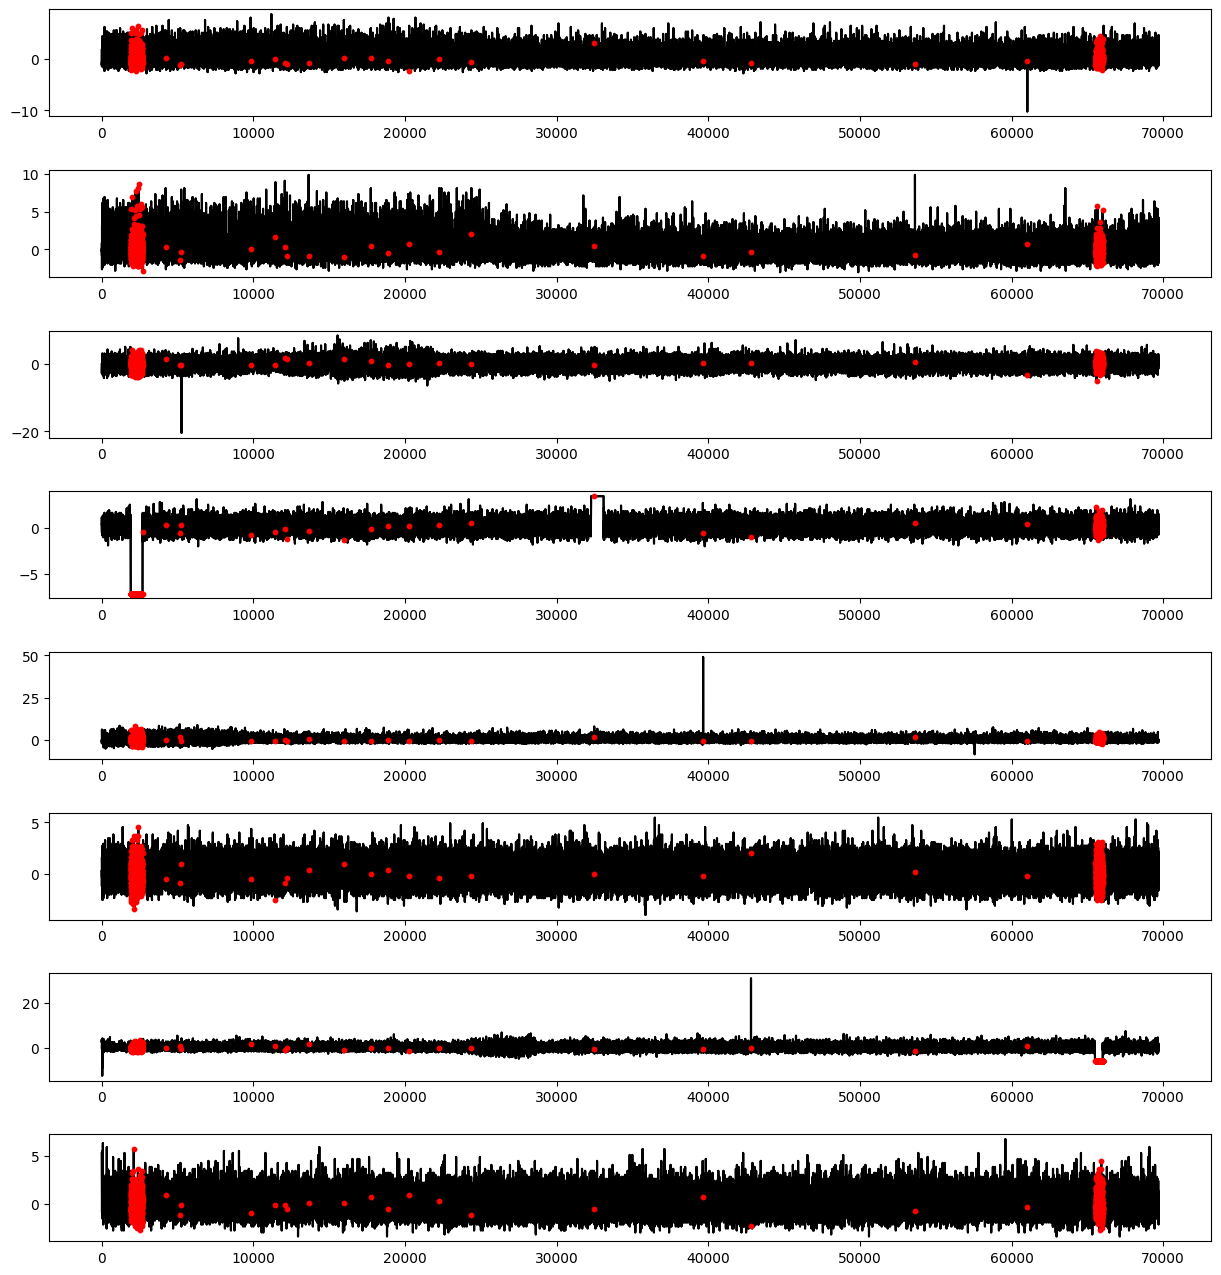

In [18]:
plot_results(data_tensor.numpy(), anomaly_scores, point_anomalies, contextual_anomalies, window_size)